In [1]:
from tqdm import tqdm,trange
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import math
from matplotlib import pyplot as plt
print("OpenCV Version : %s " % cv2.__version__)

OpenCV Version : 3.4.0 


In [20]:
pupil_area = []
pupil_center = []

# Load the video. 0 stays for binary (grayscaled, 1-channel) image loading.
cap = cv2.VideoCapture('toy_data/data.mj2',0)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# Test for crop. Will be used later in code to crop the eye region.
selection_set = False

# Start the processing. The while loop iterates over all the frames in given data set one by one.
for i in trange(length):    
    
    # Load original frames.
    _, frame = cap.read()
    
    # Select the eye region on the first frame.
    if not selection_set:
        r = cv2.selectROI(frame)
        selection_set = True
        cv2.destroyAllWindows()
    
        
    # Crop the frame according to region selected in the beginning.
    cropped = frame[r[1]:(r[1]+r[3]),r[0]:(r[0]+r[2])]
    
    ## Blur the frame. Arguments are handpicked.
    blurred = cv2.GaussianBlur(cropped,(13,13),5)
    
    ## Get rid of most of lighter coloured pixels on the image. Arguments are handpicked.
    _, thresholded = cv2.threshold(blurred,70,255,cv2.THRESH_BINARY)
    
    ## Detect the edges. Arguments are handpicked.
    edged = cv2.Canny(thresholded,100,200)
    
    try:
        _, contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Ellipse could only be fitted into a contour if it has at least 5 points. Thats why >4.
        contours = [contour for contour in contours if len(contour)>4]
        
        # Fit an ellipse into previously filtered contours.
        ellipses = [cv2.fitEllipse(contour) for contour in contours]
        
        # Compute perimeter/area ratio. If area is 0, assign arbitrary high value.
        # Thus, we are defining the most "circular" out of all the fitted ellipses.
        loss = np.asarray([cv2.arcLength(cnt,True)/cv2.contourArea(cnt) if cv2.contourArea(cnt)!=0 else 100500 for cnt in contours])
        
        # Find the index of the minimal element of these perimeter/area ratios.
        target_id = np.argmin(loss)
        
        # Draw an ellipse on the cropped image.
        ellipsed = cv2.ellipse(cropped.copy(),ellipses[target_id],(0,255,0),2)
        
        plot = plt.figure(figsize=(10,10))
        plt.plot(pupil_area)
        
        blurred = fig2data(plot)[-cropped.shape[0]-100:-100,:cropped.shape[1]]
        
        # Plot lots of sexy rat's eyes.
        result = np.vstack([np.hstack([cropped,blurred]),np.hstack([thresholded,ellipsed])])
        
        # Calculate area of fitted and position of it's center with respect to original image
        center, axes, _ = ellipses[target_id]
        ellarea = math.pi / 4 * axes[0] * axes[1]
        
        pupil_area.extend([ellarea])
        pupil_center.extend([(center[0]+r[0],center[1]+r[3])])
        
        # Temporary solution for the case of eye's blink.
    except:
        error = cv2.putText(cropped.copy(),"Achtung!", (int(cropped.shape[0]/2),int(cropped.shape[1]/2)), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)

        result = np.vstack([np.hstack([cropped,blurred]),np.hstack([thresholded,error])])
        
        pupil_area.extend([0])
        pupil_center.extend([(0,0)])
        
    # Pop-up all four steps 
    cv2.imshow('result',result)
    
    # To stop video press q
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


  0%|          | 0/90046 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)

  0%|          | 3/90046 [00:04<34:21:14,  1.37s/it]
Exception in thread Thread-16:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\ProgramData\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\ProgramData\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  4%|▍         | 3837/90046 [08:36<3:13:20,  7.43it/s]


In [10]:
blurred.shape

(9, 416, 3)

In [11]:
cropped.shape

(209, 416, 3)

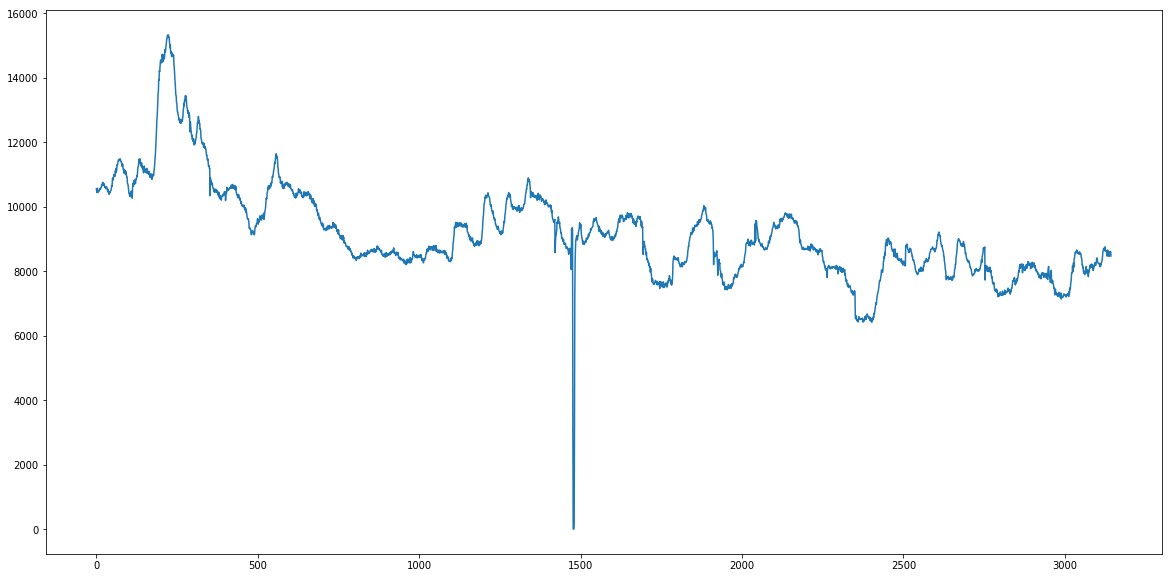

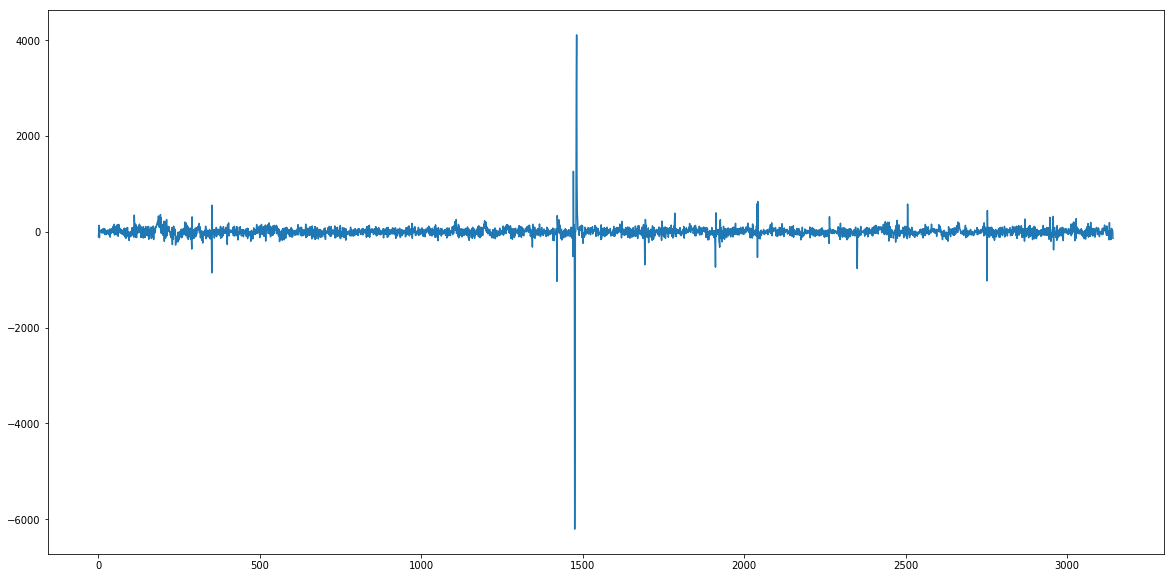

In [41]:
plt.figure(figsize=(20,10))
plt.plot(pupil_area)
plt.figure(figsize=(20,10))
plt.plot(np.diff(pupil_area))

In [38]:
np.diff(pupil_area)

array([ -99.85009495,  -18.92817211,  132.21539802, ...,   36.08190504,
         18.57927199, -137.44760067])

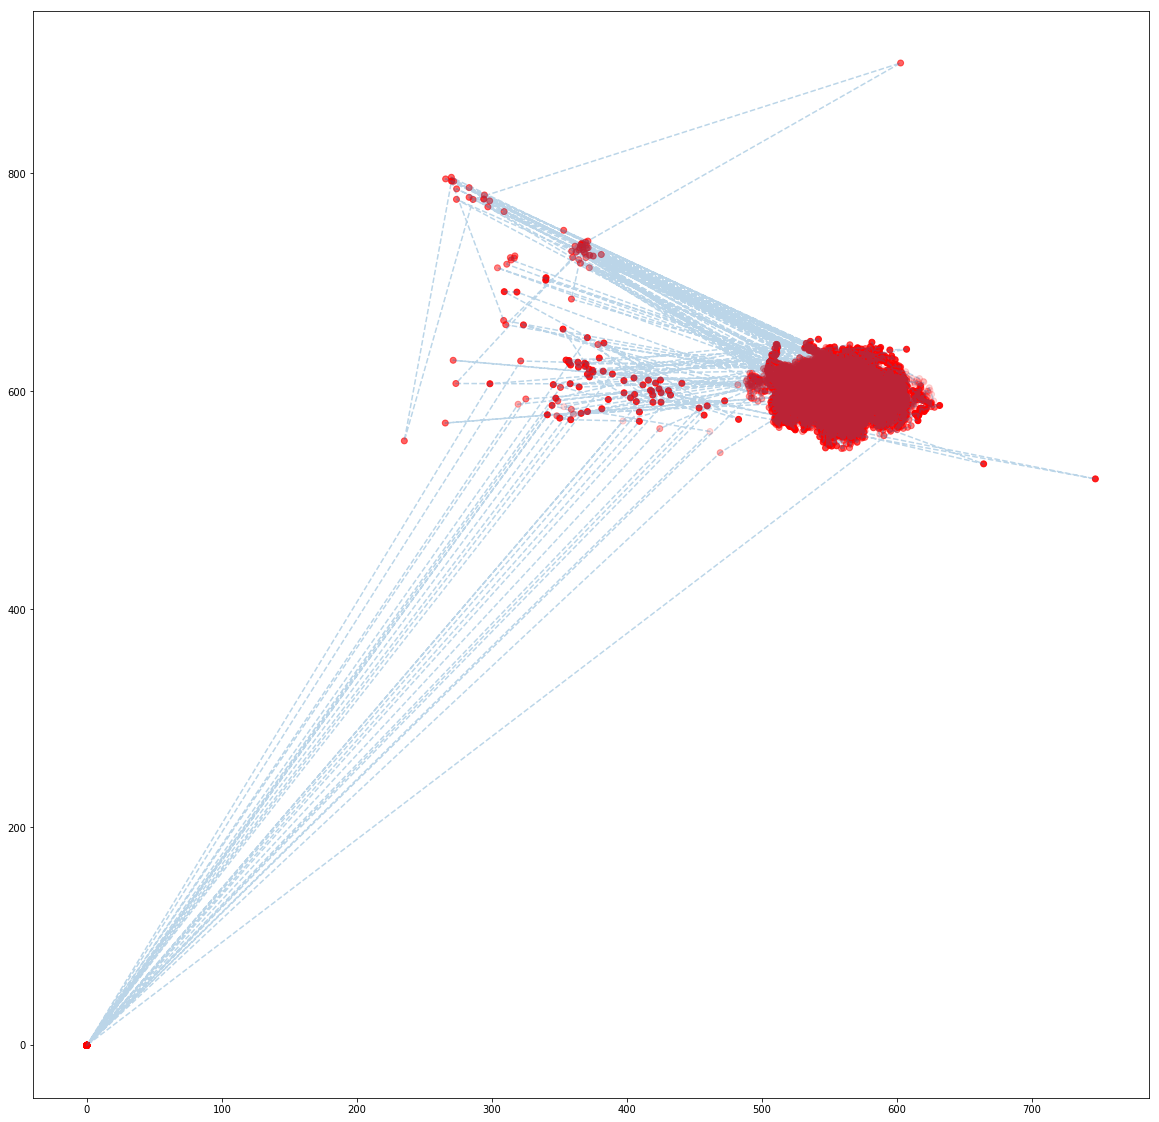

In [19]:
plt.figure(figsize=(20,20))
plt.plot([x for x,y in pupil_center],[y for x,y in pupil_center],'--',alpha=0.3)
alphas = np.linspace(0.1, 1, len(pupil_center))
rgba_colors = np.zeros((len(pupil_center),4))
rgba_colors[:,0] = 1.0
rgba_colors[:, 3] = alphas
plt.scatter([x for x,y in pupil_center],[y for x,y in pupil_center],c=rgba_colors)

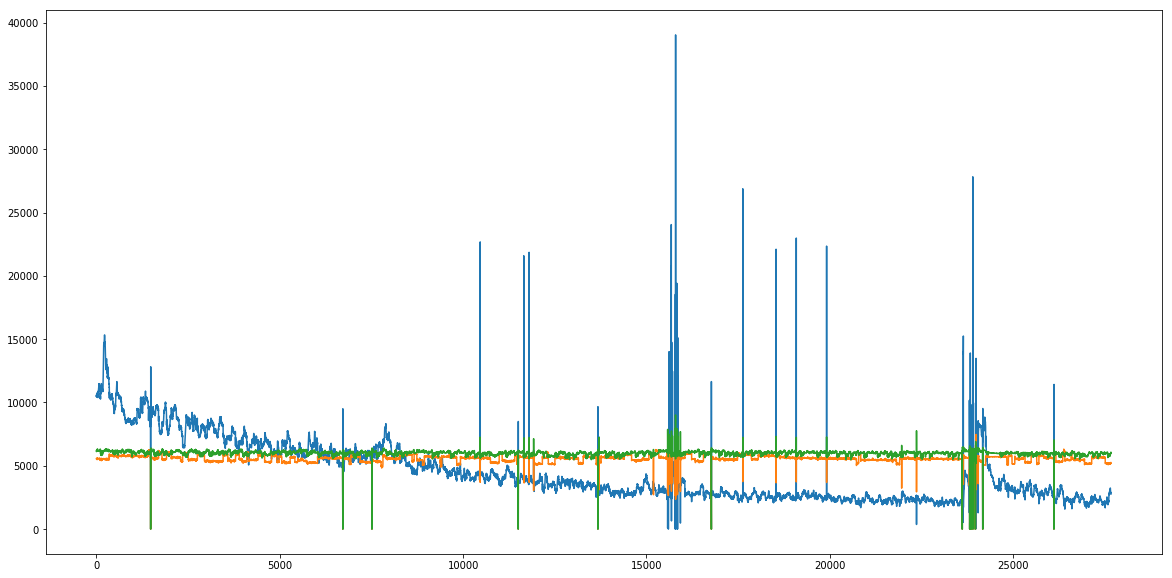

In [27]:
plt.figure(figsize=(20,10))
plt.plot(pupil_area)
plt.plot([x*10 for x,y in pupil_center])
plt.plot([y*10 for x,y in pupil_center])

In [3]:
def fig2data ( fig ):
    fig.canvas.draw ( )
 
    w,h = fig.canvas.get_width_height()
    buf = np.fromstring ( fig.canvas.tostring_rgb(), dtype=np.uint8 )
    buf.shape = ( w, h,3 )
 
    buf = np.roll ( buf, 3, axis = 2 )
    return buf

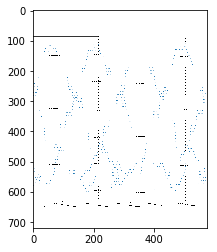

In [16]:
plt.imshow(fig2data(plot))

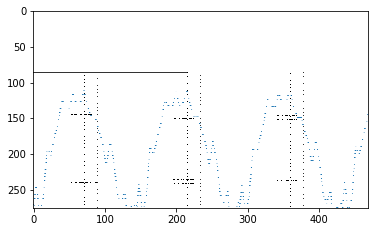

In [11]:
plt.imshow(blurred)

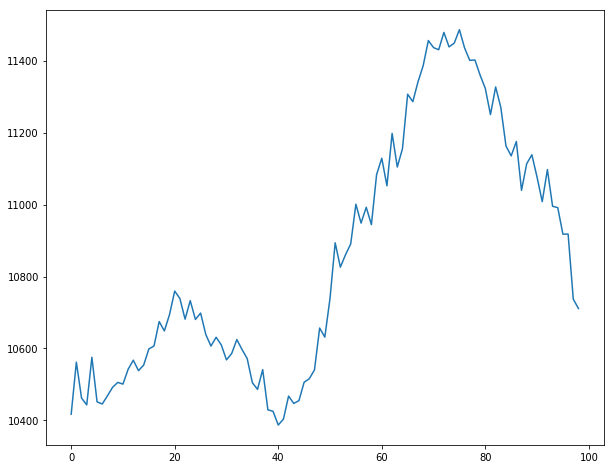

In [15]:
plot

In [76]:
from scipy.ndimage import zoom

In [80]:
cropped.shape

(256, 364, 3)

In [10]:
fig2data(fig).shape

NameError: name 'fig2data' is not defined

In [72]:
scipy.misc.imresize

AttributeError: module 'scipy' has no attribute 'misc'

In [70]:
fig2data(fig).shape

(432, 288, 4)

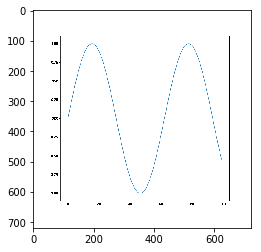

In [9]:
plt.imshow(data)

In [20]:
data.shape

(1440, 1440, 3)

In [3]:
pupil_area = [np.sin(x) for x in np.linspace(0,10,100)]

In [3]:
def fig2data(fig):
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return data

In [8]:
data.shape

(720, 720, 3)

In [12]:
cropped.shape

(330, 432, 3)

In [ ]:
pupil_area